<a href="https://colab.research.google.com/github/udlbook/udlbook/blob/main/Notebooks/Chap17/17_1_Latent_Variable_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Notebook 17.1: Latent variable models**

This notebook investigates a non-linear latent variable model similar to that in figures 17.2 and 17.3 of the book.

Work through the cells below, running each cell in turn. In various places you will see the words "TODO". Follow the instructions at these places and make predictions about what is going to happen or write code to complete the functions.

Contact me at udlbookmail@gmail.com if you find any mistakes or have any suggestions.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from matplotlib.colors import ListedColormap
from matplotlib import cm

We'll assume that our base distribution over the latent variables is a 1D standard normal so that

\begin{equation}
Pr(z) = \text{Norm}_{z}[0,1]
\end{equation}

As in figure 17.2, we'll assume that the output is two dimensional, we need to define a function that maps from the 1D latent variable to two dimensions.  Usually, we would use a neural network, but in this case, we'll just define an arbitrary relationship.

\begin{align}
x_{1} &=& 0.5\cdot\exp\Bigl[\sin\bigl[2+ 3.675 z \bigr]\Bigr]\\
x_{2} &=& \sin\bigl[2+ 2.85 z \bigr]
\end{align}

In [2]:
# The function that maps z to x1 and x2
def f(z):
  x_1 = np.exp(np.sin(2+z*3.675)) * 0.5
  x_2 = np.cos(2+z*2.85)
  return x_1, x_2

Let's plot the 3D relation between the two observed variables $x_{1}$ and $x_{2}$ and the latent variables $z$ as in figure 17.2 of the book.  We'll use the opacity to represent the prior probability $Pr(z)$.

In [3]:
def draw_3d_projection(z,pr_z, x1,x2):
  alpha = pr_z / np.max(pr_z)
  ax = plt.axes(projection='3d')
  fig = plt.gcf()
  fig.set_size_inches(18.5, 10.5)
  for i in range(len(z)-1):
    ax.plot([z[i],z[i+1]],[x1[i],x1[i+1]],[x2[i],x2[i+1]],'r-', alpha=pr_z[i])
  ax.set_xlabel('$z$',)
  ax.set_ylabel('$x_1$')
  ax.set_zlabel('$x_2$')
  ax.set_xlim(-3,3)
  ax.set_ylim(0,2)
  ax.set_zlim(-1,1)
  ax.set_box_aspect((3,1,1))
  plt.show()

In [4]:
# Compute the prior
def get_prior(z):
  return scipy.stats.multivariate_normal.pdf(z)

-6.394884621840902e-14
0.3989422804014327


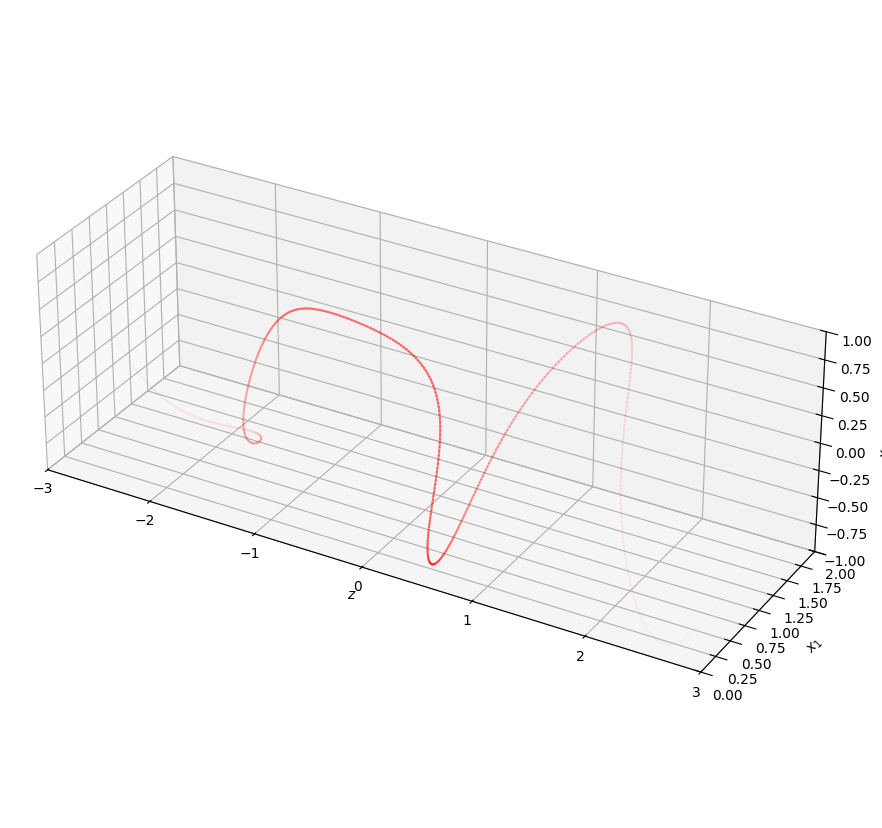

In [5]:
# Define the latent variable values
z = np.arange(-3.0,3.0,0.01)
# Find the probability distribution over z
# same distribution for different z
# probability of z under N(0, I)
pr_z = get_prior(z)

# very close to 0
print(z[pr_z.shape[0] // 2])
print(pr_z[pr_z.shape[0] // 2])

# Compute x1 and x2 for each z
# which determines the mean of gaussian distr N(u, sigma*I) = Pr(x|z) for this z
x1,x2 = f(z)
# Plot the function
# more red at this z => higher prob of this z
draw_3d_projection(z,pr_z, x1,x2)

The likelihood is defined as:
\begin{align}
 Pr(x_1,x_2|z) &=&  \text{Norm}_{[x_1,x_2]}\Bigl[\mathbf{f}[z],\sigma^{2}\mathbf{I}\Bigr]
\end{align}

so we will also need to define the noise level $\sigma^2$

In [6]:
sigma_sq = 0.04

In [7]:
# Draws a heatmap to represent a probability distribution, possibly with samples overlaed
def plot_heatmap(x1_mesh,x2_mesh,y_mesh, x1_samples=None, x2_samples=None, title=None):
  # Define pretty colormap
  my_colormap_vals_hex =('2a0902', '2b0a03', '2c0b04', '2d0c05', '2e0c06', '2f0d07', '300d08', '310e09', '320f0a', '330f0b', '34100b', '35110c', '36110d', '37120e', '38120f', '39130f', '3a1410', '3b1411', '3c1511', '3d1612', '3e1613', '3f1713', '401714', '411814', '421915', '431915', '451a16', '461b16', '471b17', '481c17', '491d18', '4a1d18', '4b1e19', '4c1f19', '4d1f1a', '4e201b', '50211b', '51211c', '52221c', '53231d', '54231d', '55241e', '56251e', '57261f', '58261f', '592720', '5b2821', '5c2821', '5d2922', '5e2a22', '5f2b23', '602b23', '612c24', '622d25', '632e25', '652e26', '662f26', '673027', '683027', '693128', '6a3229', '6b3329', '6c342a', '6d342a', '6f352b', '70362c', '71372c', '72372d', '73382e', '74392e', '753a2f', '763a2f', '773b30', '783c31', '7a3d31', '7b3e32', '7c3e33', '7d3f33', '7e4034', '7f4134', '804235', '814236', '824336', '834437', '854538', '864638', '874739', '88473a', '89483a', '8a493b', '8b4a3c', '8c4b3c', '8d4c3d', '8e4c3e', '8f4d3f', '904e3f', '924f40', '935041', '945141', '955242', '965343', '975343', '985444', '995545', '9a5646', '9b5746', '9c5847', '9d5948', '9e5a49', '9f5a49', 'a05b4a', 'a15c4b', 'a35d4b', 'a45e4c', 'a55f4d', 'a6604e', 'a7614e', 'a8624f', 'a96350', 'aa6451', 'ab6552', 'ac6552', 'ad6653', 'ae6754', 'af6855', 'b06955', 'b16a56', 'b26b57', 'b36c58', 'b46d59', 'b56e59', 'b66f5a', 'b7705b', 'b8715c', 'b9725d', 'ba735d', 'bb745e', 'bc755f', 'bd7660', 'be7761', 'bf7862', 'c07962', 'c17a63', 'c27b64', 'c27c65', 'c37d66', 'c47e67', 'c57f68', 'c68068', 'c78169', 'c8826a', 'c9836b', 'ca846c', 'cb856d', 'cc866e', 'cd876f', 'ce886f', 'ce8970', 'cf8a71', 'd08b72', 'd18c73', 'd28d74', 'd38e75', 'd48f76', 'd59077', 'd59178', 'd69279', 'd7937a', 'd8957b', 'd9967b', 'da977c', 'da987d', 'db997e', 'dc9a7f', 'dd9b80', 'de9c81', 'de9d82', 'df9e83', 'e09f84', 'e1a185', 'e2a286', 'e2a387', 'e3a488', 'e4a589', 'e5a68a', 'e5a78b', 'e6a88c', 'e7aa8d', 'e7ab8e', 'e8ac8f', 'e9ad90', 'eaae91', 'eaaf92', 'ebb093', 'ecb295', 'ecb396', 'edb497', 'eeb598', 'eeb699', 'efb79a', 'efb99b', 'f0ba9c', 'f1bb9d', 'f1bc9e', 'f2bd9f', 'f2bfa1', 'f3c0a2', 'f3c1a3', 'f4c2a4', 'f5c3a5', 'f5c5a6', 'f6c6a7', 'f6c7a8', 'f7c8aa', 'f7c9ab', 'f8cbac', 'f8ccad', 'f8cdae', 'f9ceb0', 'f9d0b1', 'fad1b2', 'fad2b3', 'fbd3b4', 'fbd5b6', 'fbd6b7', 'fcd7b8', 'fcd8b9', 'fcdaba', 'fddbbc', 'fddcbd', 'fddebe', 'fddfbf', 'fee0c1', 'fee1c2', 'fee3c3', 'fee4c5', 'ffe5c6', 'ffe7c7', 'ffe8c9', 'ffe9ca', 'ffebcb', 'ffeccd', 'ffedce', 'ffefcf', 'fff0d1', 'fff2d2', 'fff3d3', 'fff4d5', 'fff6d6', 'fff7d8', 'fff8d9', 'fffada', 'fffbdc', 'fffcdd', 'fffedf', 'ffffe0')
  my_colormap_vals_dec = np.array([int(element,base=16) for element in my_colormap_vals_hex])
  r = np.floor(my_colormap_vals_dec/(256*256))
  g = np.floor((my_colormap_vals_dec - r *256 *256)/256)
  b = np.floor(my_colormap_vals_dec - r * 256 *256 - g * 256)
  my_colormap = ListedColormap(np.vstack((r,g,b)).transpose()/255.0)

  fig,ax = plt.subplots()
  fig.set_size_inches(8,8)
  ax.contourf(x1_mesh,x2_mesh,y_mesh,256,cmap=my_colormap)
  ax.contour(x1_mesh,x2_mesh,y_mesh,8,colors=['#80808080'])
  if title is not None:
    ax.set_title(title);
  if x1_samples is not None:
    ax.plot(x1_samples, x2_samples, 'c.')
  ax.set_xlim([-0.5,2.5])
  ax.set_ylim([-1.5,1.5])
  ax.set_xlabel('$x_1$'); ax.set_ylabel('$x_2$')
  plt.show()



In [8]:
# Returns the likelihood
def get_likelihood(x1_mesh, x2_mesh, z_val):
  # Find the corresponding x1 and x2 values
  x1,x2 = f(z_val)

  # Calculate the probability for a mesh of x1,x2 values.
  mn = scipy.stats.multivariate_normal([x1, x2], [[sigma_sq, 0], [0, sigma_sq]])
  pr_x1_x2_given_z_val = mn.pdf(np.dstack((x1_mesh, x2_mesh)))
  return pr_x1_x2_given_z_val

Now let's plot the likelihood $Pr(x_1,x_2|z)$ as in fig 17.3b in the book.

(300, 300)


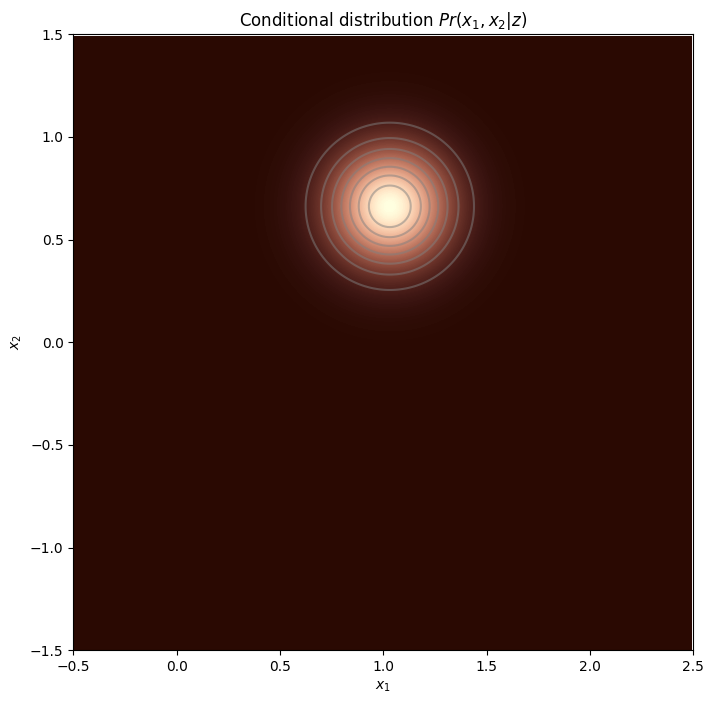

In [9]:
# Choose some z value
z_val = 1.8

# Compute the conditional distribution on a grid
x1_mesh, x2_mesh = np.meshgrid(np.arange(-0.5,2.5,0.01), np.arange(-1.5,1.5,0.01))
pr_x1_x2_given_z_val = get_likelihood(x1_mesh,x2_mesh, z_val)

print(pr_x1_x2_given_z_val.shape)

# Plot the result
plot_heatmap(x1_mesh, x2_mesh, pr_x1_x2_given_z_val, title="Conditional distribution $Pr(x_1,x_2|z)$")

# TODO -- Experiment with different values of z and make sure that you understand the what is happening.
# sample some value from z ~ pz = N(0, 1) ->
# given some function f (usually a neural network), 
# get the distribution Pr(x|z) = N(f(z), sigma*I) with this sampled z

# Ans: when we change z, we change the mean of normal distribution given by N(f(z), sigma*I)

The data density is found by marginalizing over the latent variables $z$:

\begin{align}
 Pr(x_1,x_2) &=& \int Pr(x_1,x_2, z) dz \nonumber \\
 &=& \int Pr(x_1,x_2 | z) \cdot Pr(z)dz\nonumber \\
 &=& \int \text{Norm}_{[x_1,x_2]}\Bigl[\mathbf{f}[z],\sigma^{2}\mathbf{I}\Bigr]\cdot \text{Norm}_{z}\left[\mathbf{0},\mathbf{I}\right]dz.
\end{align}

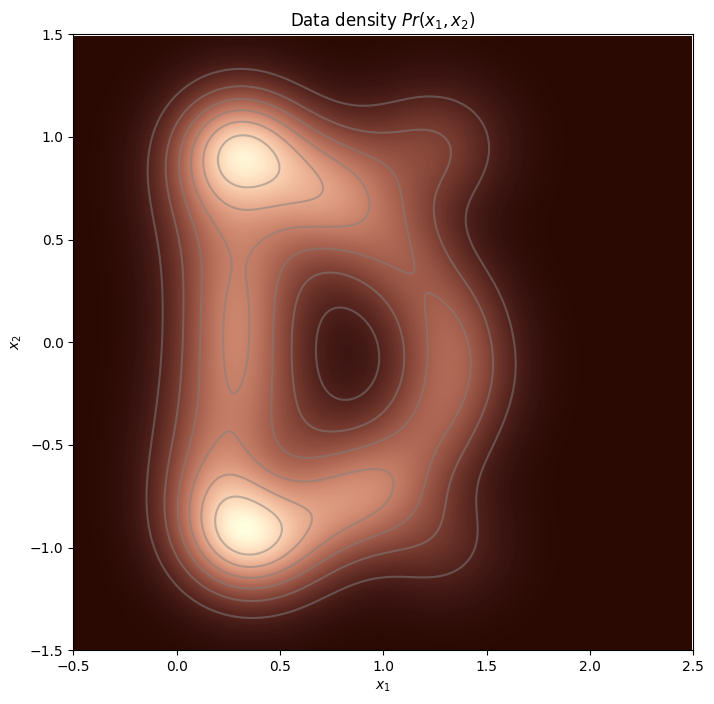

In [10]:
# TODO Compute the data density
# We can't integrate this function in closed form
# So let's approximate it as a sum over the z values (z = np.arange(-3,3,0.01))
# You will need the functions get_likelihood() and get_prior()
# To make this a valid probability distribution, you need to divide
# By the z-increment (0.01)
# Replace this line

def get_data_density1(interval_range=3, z_increment=0.1):
    pr_x1_x2 = None

    z_range = np.arange(-interval_range, interval_range, z_increment)
    # prior probabilities for this range of zs
    pr_z = get_prior(z_range)
    
    # mesh to calculate the prx1x2 given z
    x1_mesh, x2_mesh = np.meshgrid(np.arange(-0.5,2.5,0.01), np.arange(-1.5,1.5,0.01))
    
    for index, z_val in enumerate(z_range):
        # likelihood of this zval
        pr_x1_x2_given_z_val = get_likelihood(x1_mesh, x2_mesh, z_val)
        
        # sum the joint probability 
        if pr_x1_x2 is None:
            pr_x1_x2 = pr_x1_x2_given_z_val * pr_z[index]
        else:
            pr_x1_x2 += pr_x1_x2_given_z_val * pr_z[index]

    # normalize
    pr_x1_x2 *= z_increment
    
    return pr_x1_x2

def get_data_density2(interval_range=3, z_increment=0.1):

    z_range = np.arange(-interval_range, interval_range, z_increment)
    # prior probabilities for this range of zs
    pr_z = get_prior(z_range)
    
    # mesh to calculate the prx1x2 given z
    x1_mesh, x2_mesh = np.meshgrid(np.arange(-0.5,2.5,0.01), np.arange(-1.5,1.5,0.01))
    
    # store likelihoods for each z
    pr_x1_x2_given_z_range = np.zeros((z_range.shape[0], x2_mesh.shape[0], x1_mesh.shape[1]))
    
    # likelihood for each z
    for index, z_val in enumerate(z_range):
        pr_x1_x2_given_z_range[index] = get_likelihood(x1_mesh, x2_mesh, z_val)

    # reshape to broadcast    
    broadcast_pr_z = pr_z.reshape(-1, 1, 1)
    
    # calculate pr_x1_x2
    joint_prob = broadcast_pr_z * pr_x1_x2_given_z_range
    pr_x1_x2 = np.sum(joint_prob, axis=0) * z_increment
    
    return pr_x1_x2
    


pr_x1_x2 = get_data_density1()

# Plot the result
plot_heatmap(x1_mesh, x2_mesh, pr_x1_x2, title="Data density $Pr(x_1,x_2)$")


Now let's draw some samples from the model

In [11]:
def draw_samples(n_sample, sigma_sq):
    # TODO Write this routine to draw n_sample samples from the model
    # First draw a random value of z from the prior (a standard normal distribution)
    # Then draw a sample from Pr(x1,x2|z)
    # Replace this line
    
    # Pr(z) = N(0, 1)
    z_samples = np.random.normal(loc=0.0, scale=1.0, size=n_sample)

    x1_samples = np.zeros(n_sample)
    x2_samples = np.zeros(n_sample)
    
    for i, z_val in enumerate(z_samples):
        x1_mean, x2_mean = f(z_val)
        
        # Pr(x1, x2 | z) = N(f(z), sigma * I)
        # also could sample from get_likelihood?
        sample = np.random.multivariate_normal(
            mean=[x1_mean, x2_mean],
            cov=[[sigma_sq, 0], [0, sigma_sq]]
        )

        x1_samples[i], x2_samples[i] = sample

    return x1_samples, x2_samples

Let's plot those samples on top of the heat map.

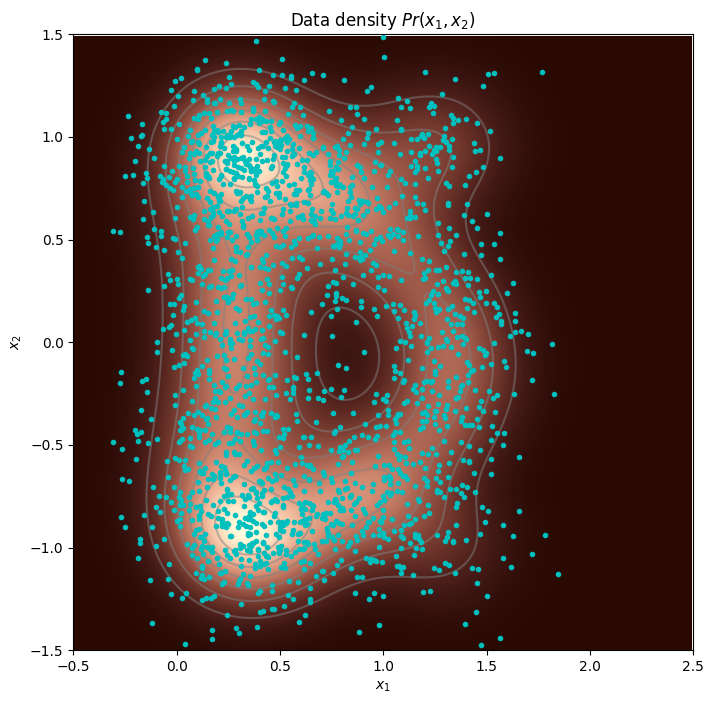

In [12]:
x1_samples, x2_samples = draw_samples(2000, sigma_sq)
# Plot the result
plot_heatmap(x1_mesh, x2_mesh, pr_x1_x2, x1_samples, x2_samples, title="Data density $Pr(x_1,x_2)$")


In [ ]:
# Return the posterior distribution
def get_posterior(x1,x2):
    z = np.arange(-3,3, 0.01)
    # TODO -- write this function
    # Again, we can't integrate, but we can sum
    # We don't know the constant in the denominator of equation 17.19, but we can just normalize
    # by the sum of the numerators for all values of z
    # Replace this line:
    pr_x1_x2_given_z = np.zeros_like(z)

    # Pr(z) = N(0, 1): probability of this z
    pr_z = get_prior(z)
    
    for index, z_val in enumerate(z):
        x1_mean, x2_mean = f(z_val)
        
        # Pr(x1, x2 | z) = N(f(z), sigma * I)
        sample = scipy.stats.multivariate_normal.pdf(
            [x1, x2],
            mean=[x1_mean, x2_mean],
            cov=[[sigma_sq, 0], [0, sigma_sq]]
        )

        pr_x1_x2_given_z[index] = sample
        
    numerator_pr_z_given_x = pr_x1_x2_given_z * pr_z
    
    # normalize, why can we do that?
    # it's an approximation of the real distribution
    pr_z_given_x1_x2 = numerator_pr_z_given_x / np.sum(numerator_pr_z_given_x)


    return z, pr_z_given_x1_x2

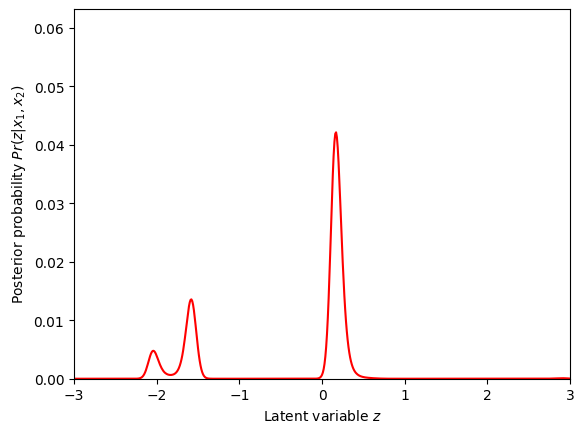

In [30]:
x1 = 0.9; x2 = -0.9
z, pr_z_given_x1_x2 = get_posterior(x1,x2)


fig, ax = plt.subplots()
ax.plot(z, pr_z_given_x1_x2, 'r-')
ax.set_xlabel("Latent variable $z$")
ax.set_ylabel("Posterior probability $Pr(z|x_{1},x_{2})$")
ax.set_xlim([-3,3])
ax.set_ylim([0,1.5 * np.max(pr_z_given_x1_x2)])
plt.show()